## Data Augmentation

**Data augmentation** is the process of artificially generating new data from existing data, primarily to train new machine learning (ML) models.

Commonly used operations:
1. Rotation
2. Shearing
3. Zooming
4. Cropping
5. Flipping
6. Changing the brightness level

A combination of operations can be applied. 

Python libraries/modules:
* [PyTorch](https://pytorch.org/) -torchvision.transforms
* [Albumentations](https://github.com/albumentations-team/albumentations)
* [imgaug](https://github.com/aleju/imgaug)

<img src="./rsc/pytorch.png" width="300" height="400"> <img src="./rsc/albumentations.png" width="300" height="400"> <img src="./rsc/imgaug.png" width="300" height="400">

*further reading*:
* [Python | Data Augmentation](https://www.geeksforgeeks.org/python-data-augmentation/)

### Data Augmentation with PyTorch (torchvision)

>TL;DR We recommending using the torchvision.transforms.v2 transforms instead of those in torchvision.transforms. They’re faster and they can do more things. Just change the import and you should be good to go.
>
>In Torchvision 0.15 (March 2023), we released a new set of transforms available in the torchvision.transforms.v2 namespace. These transforms have a lot of advantages compared to the v1 ones (in torchvision.transforms):
Reference:
* [Transforming and augmenting images](https://pytorch.org/vision/0.16/transforms.html)

In [26]:
import torchvision 
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [30]:
transform = transforms.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomCrop(32, padding=4),
    v2.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_data = CIFAR10('./data/cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=6, shuffle=True, num_workers=6)

Files already downloaded and verified


In [31]:
im, label = train_data[0]

In [32]:
import matplotlib.pyplot as plt

In [33]:
im.shape

torch.Size([3, 32, 32])

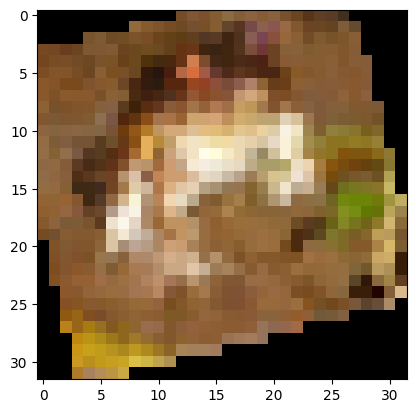

In [34]:
im = im.permute(1,2,0)
plt.imshow(im/2+0.5)

In [35]:
X, y =next(iter(train_loader))
X.shape

torch.Size([6, 3, 32, 32])

In [38]:
X = make_grid(X).permute(1,2,0)
X.shape

torch.Size([36, 206, 3])

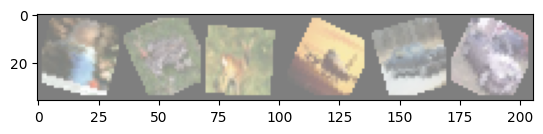

In [39]:
X = X/2 + 0.5
plt.imshow(X)

#### Transform for Validation

for validation dataset, you should not perform data augmentation. It is **traning ONLY**. 

In [ ]:
transform = transforms.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomCrop(32, padding=4),
    v2.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_data = CIFAR10('./data/cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=6, shuffle=True, num_workers=6)
val_data = CIFAR10('./data/cifar10_data', train=False, download=True, transform=transform_val)
val_loader = DataLoader(val_data, batch_size=6, num_workers=6)

### Data Augmentation with Albumentations

installation:
```python
pip install albumentations
```
* [Albumentations](https://albumentations.ai/docs/getting_started/image_augmentation/) tutorials
* [Albumentations-API](https://albumentations.ai/docs/api_reference/full_reference/)

In [47]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

In [55]:
transform=A.Compose([
    A.HorizontalFlip(),
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.RandomCrop(height=32,width=32),
    A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Normalize(mean=([0.5,0.5,0.5]), std=([0.5,0.5,0.5])),
    ToTensorV2(),
])

Files already downloaded and verified


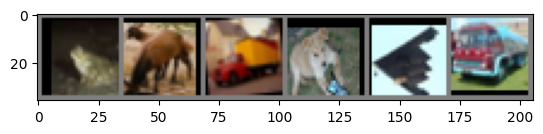

In [57]:
# wrapper class
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self,image, target=None):
        image = self.transform(image=np.array(image))['image']
        if target:
            return image, target
        else:
            return image

transform_alb = AlbumentationsTransform(transform)
train_data = CIFAR10('./data/cifar10_data', train=True, download=True, transform=transform_alb)
train_loader = DataLoader(train_data, batch_size=6, shuffle=True, num_workers=6)

X, y =next(iter(train_loader))
X = make_grid(X).permute(1,2,0)
X = X/2 + 0.5
plt.imshow(X)

### Data Augmentation with imgaug

[imgaug Docs](https://imgaug.readthedocs.io/en/latest/)

In [62]:
# pip install imgaug
from imgaug import augmenters as iaa
import imgaug as ia

In [89]:
transform_ia_seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Pad(px=4),
    iaa.CropToFixedSize(width=32, height=32),
    iaa.Affine(rotate=(-30,30))
])

class ImgAugTransform:
    def __init__(self, ia_seq):
        self.ia_seq = ia_seq

    def __call__(self, image, target=None): # image: PIL format
        image = self.ia_seq.augment_image(np.array(image))
        if target:
            return image, target
        else:
            return image

Files already downloaded and verified


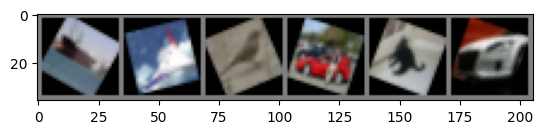

In [90]:
transform_ia = ImgAugTransform(transform_ia_seq)

transform = transforms.Compose([
    transform_ia,
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_data = CIFAR10('./data/cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=6, shuffle=True, num_workers=6)

X, y =next(iter(train_loader))
X = make_grid(X).permute(1,2,0)
X = X/2 + 0.5
plt.imshow(X)

### Use Data Augmentation in Training

In [127]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914,0.4822,0.4465), std=(0.2023,0.1994,0.2010))
])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914,0.4822,0.4465), std=(0.2023,0.1994,0.2010))
])

train_data = torchvision.datasets.CIFAR10(root='./data/cifar10_data', train=True, download=True, transform=transform)
val_data = torchvision.datasets.CIFAR10(root='./data/cifar10_data', train=False, download=True, transform=transform_val)

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [129]:
im, label = next(iter(train_loader))
im.shape

torch.Size([128, 3, 32, 32])

In [135]:
conv_model = utils.get_conv_model(in_ch=3)
opt = optim.Adam(conv_model.parameters(), lr=0.03)
act_stats = utils.ActivationStatistics(conv_model)

num_epoch = 30
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=num_epoch)

epoch: 0: train error: 1.7550548327243543, validation error: 1.5531217372870143, validation accuracy: 0.432753164556962


epoch: 1: train error: 1.601118753938114, validation error: 1.4600612151471875, validation accuracy: 0.4664754746835443


epoch: 2: train error: 1.5426626723745596, validation error: 1.3941194603714762, validation accuracy: 0.4880340189873418


epoch: 3: train error: 1.5100516465009022, validation error: 1.4170719807661032, validation accuracy: 0.47972705696202533


epoch: 4: train error: 1.490575827905894, validation error: 1.3925987059556986, validation accuracy: 0.5015822784810127


epoch: 5: train error: 1.4753938020037873, validation error: 1.3573183711571029, validation accuracy: 0.5096914556962026


epoch: 6: train error: 1.464423007367517, validation error: 1.3524647664420213, validation accuracy: 0.5114715189873418


epoch: 7: train error: 1.4590997537383643, validation error: 1.3661134725884547, validation accuracy: 0.5107792721518988


epoch: 8: train error: 1.4491639558006735, validation error: 1.326804764663117, validation accuracy: 0.5164161392405063


epoch: 9: train error: 1.4410249988746155, validation error: 1.35268757011317, validation accuracy: 0.5090981012658228


epoch: 10: train error: 1.428659344268272, validation error: 1.3663324902329264, validation accuracy: 0.504746835443038


epoch: 11: train error: 1.4318236240645503, validation error: 1.323740589467785, validation accuracy: 0.5245253164556962


epoch: 12: train error: 1.4227856861051087, validation error: 1.2865920760963536, validation accuracy: 0.5364912974683544


epoch: 13: train error: 1.4151881494180625, validation error: 1.3115484639059138, validation accuracy: 0.5290743670886076


epoch: 14: train error: 1.4091459387708503, validation error: 1.3031588159029996, validation accuracy: 0.5244264240506329


epoch: 15: train error: 1.4118266203214445, validation error: 1.290728505653671, validation accuracy: 0.538370253164557


epoch: 16: train error: 1.4069251087315553, validation error: 1.328641959383518, validation accuracy: 0.5191851265822784


epoch: 17: train error: 1.3980770370234614, validation error: 1.27527752858174, validation accuracy: 0.5396558544303798


epoch: 18: train error: 1.3983379419502395, validation error: 1.2911268004888221, validation accuracy: 0.5389636075949367


epoch: 19: train error: 1.3979495727192714, validation error: 1.2630601502672028, validation accuracy: 0.5449960443037974


epoch: 20: train error: 1.3973085785765782, validation error: 1.2982900912248636, validation accuracy: 0.5362935126582279


epoch: 21: train error: 1.3912068599325311, validation error: 1.263833506197869, validation accuracy: 0.5503362341772152


epoch: 22: train error: 1.3955971557465965, validation error: 1.2640337476247474, validation accuracy: 0.5481606012658228


epoch: 23: train error: 1.3969692702183638, validation error: 1.265095682083806, validation accuracy: 0.5398536392405063


epoch: 24: train error: 1.3905565625871235, validation error: 1.262581208084203, validation accuracy: 0.5494462025316456


epoch: 25: train error: 1.38513095878884, validation error: 1.2694470158106164, validation accuracy: 0.5465783227848101


epoch: 26: train error: 1.3890834443099664, validation error: 1.280572136746177, validation accuracy: 0.5339200949367089


epoch: 27: train error: 1.3844265501822353, validation error: 1.2549854879137836, validation accuracy: 0.5494462025316456


epoch: 28: train error: 1.3874133124071009, validation error: 1.242889879625055, validation accuracy: 0.551621835443038


epoch: 29: train error: 1.3833234227831712, validation error: 1.2717810159997096, validation accuracy: 0.5395569620253164


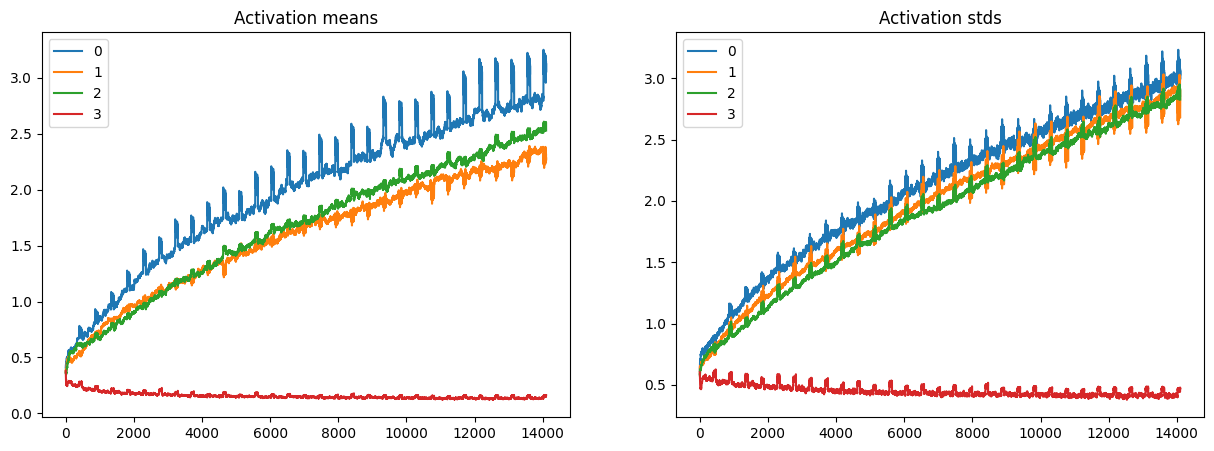

In [136]:
act_stats.plot_statistics()

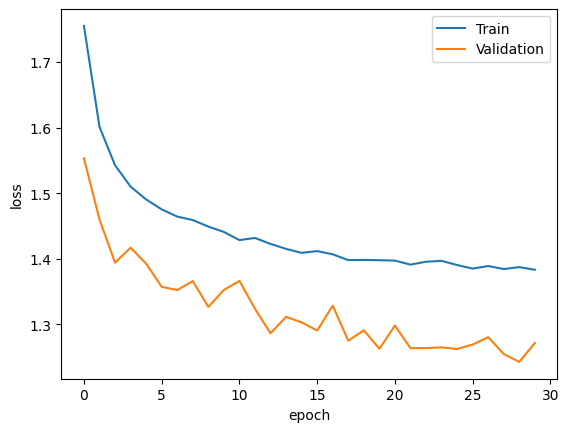

In [137]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [138]:
# no augmentation : use tansform_val
train_data_no_aug = torchvision.datasets.CIFAR10(root='./data/cifar10_data', train=True, download=True, transform=transform_val)

train_loader_no_aug = DataLoader(train_data_no_aug, batch_size=batch_size, shuffle=True, num_workers=4)

conv_model_no_aug = utils.get_conv_model(in_ch=3)
opt_no_aug = optim.Adam(conv_model_no_aug.parameters(), lr=0.03)

num_epoch = 30
train_losses_no_aug, val_losses_no_aug, val_accuracies_no_aug = utils.learn(conv_model_no_aug, train_loader_no_aug, val_loader, opt_no_aug, F.cross_entropy, num_epoch=num_epoch)

Files already downloaded and verified


epoch: 0: train error: 1.5910946127703733, validation error: 1.41008005413828, validation accuracy: 0.47606803797468356


epoch: 1: train error: 1.34617360199199, validation error: 1.3248372425006916, validation accuracy: 0.521756329113924


epoch: 2: train error: 1.2647491169097784, validation error: 1.3018692286708686, validation accuracy: 0.5375791139240507


epoch: 3: train error: 1.2158469630934088, validation error: 1.2337719496292403, validation accuracy: 0.5637856012658228


epoch: 4: train error: 1.1816195144372827, validation error: 1.250148810917818, validation accuracy: 0.5464794303797469


epoch: 5: train error: 1.1582702631535737, validation error: 1.1818492736997483, validation accuracy: 0.5784216772151899


epoch: 6: train error: 1.1415864532560949, validation error: 1.2047695434546168, validation accuracy: 0.5720925632911392


epoch: 7: train error: 1.126587796546614, validation error: 1.1765598254867746, validation accuracy: 0.5778283227848101


epoch: 8: train error: 1.116252090619958, validation error: 1.192721344247649, validation accuracy: 0.5819818037974683


epoch: 9: train error: 1.103563493474975, validation error: 1.179081051409999, validation accuracy: 0.5783227848101266


epoch: 10: train error: 1.0974554523177769, validation error: 1.1816493272781372, validation accuracy: 0.5803995253164557


epoch: 11: train error: 1.0877673238744516, validation error: 1.163961112499237, validation accuracy: 0.5869264240506329


epoch: 12: train error: 1.0845630091169607, validation error: 1.1447769818426687, validation accuracy: 0.5931566455696202


epoch: 13: train error: 1.0752526835712326, validation error: 1.1319933707201029, validation accuracy: 0.596815664556962


epoch: 14: train error: 1.0702016222507447, validation error: 1.1467946458466445, validation accuracy: 0.5936511075949367


epoch: 15: train error: 1.0614993867971707, validation error: 1.1690591000303436, validation accuracy: 0.5827729430379747


epoch: 16: train error: 1.0619789633299688, validation error: 1.1704778354379195, validation accuracy: 0.586629746835443


epoch: 17: train error: 1.0530577673936439, validation error: 1.1247753184052962, validation accuracy: 0.595431170886076


epoch: 18: train error: 1.0523556382454875, validation error: 1.151824017114277, validation accuracy: 0.5925632911392406


epoch: 19: train error: 1.0470818377211881, validation error: 1.1629510650151893, validation accuracy: 0.5829707278481012


epoch: 20: train error: 1.0507505914134443, validation error: 1.1734508751313897, validation accuracy: 0.5832674050632911


epoch: 21: train error: 1.0375425513748013, validation error: 1.1275281415709966, validation accuracy: 0.6042325949367089


epoch: 22: train error: 1.0375232934342016, validation error: 1.1283429053765308, validation accuracy: 0.5974090189873418


epoch: 23: train error: 1.0337186306333908, validation error: 1.1861038705970668, validation accuracy: 0.5784216772151899


epoch: 24: train error: 1.0319861643149724, validation error: 1.138087601601323, validation accuracy: 0.6019580696202531


epoch: 25: train error: 1.0273770343921984, validation error: 1.1309660099729706, validation accuracy: 0.603243670886076


epoch: 26: train error: 1.0284342503608646, validation error: 1.1723311211489424, validation accuracy: 0.5831685126582279


epoch: 27: train error: 1.0252822878415628, validation error: 1.127031671095498, validation accuracy: 0.5981012658227848


epoch: 28: train error: 1.0210981611400614, validation error: 1.1425517895553685, validation accuracy: 0.6003757911392406


epoch: 29: train error: 1.0191597222062327, validation error: 1.1664296411260773, validation accuracy: 0.5859375


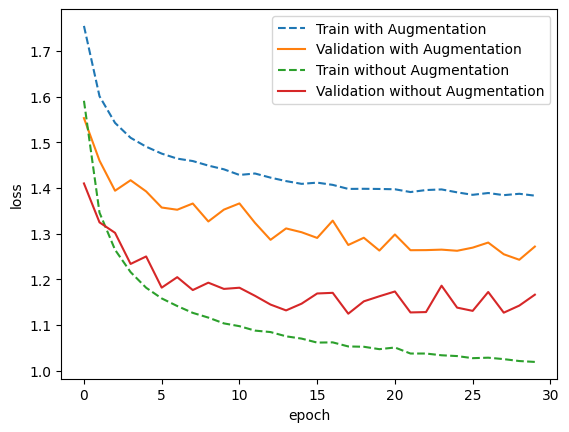

In [140]:
plt.plot(train_losses, '--',label='Train with Augmentation')
plt.plot(val_losses, label='Validation with Augmentation')
plt.plot(train_losses_no_aug,'--', label='Train without Augmentation')
plt.plot(val_losses_no_aug, label='Validation without Augmentation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

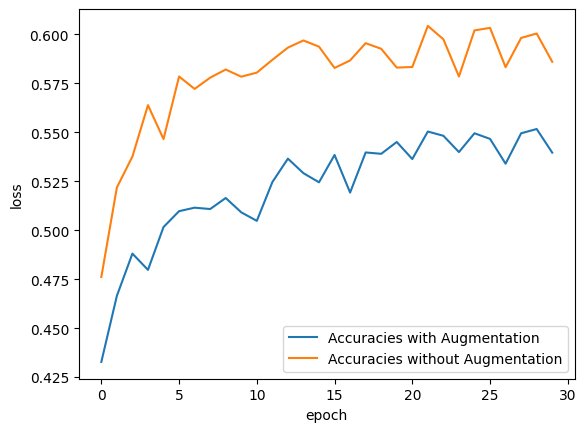

In [142]:
plt.plot(val_accuracies, label='Accuracies with Augmentation')
plt.plot(val_accuracies_no_aug, label='Accuracies without Augmentation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()